## Model evaluation

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras.models import Sequential
import scipy.signal as signal
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### 1. Evaluating the models with the MS and WISDM datasets

In [5]:
#Reading the testing datasets
df_ms = pd.read_csv('./01_rawdata/raw_ms_all0926_df.csv') # read in the ms datasets
df_wd = pd.read_csv('./01_rawdata/raw_wisdm0926_df.csv')  # read in the wisdm datasets

In [6]:
# Manually setup training and testing datasets for both WISDM and MS
df_wd_train = df_wd[df_wd['user_id'] <= 30]
df_wd_test = df_wd[df_wd['user_id'] > 30]
df_ms_train = df_ms[df_ms['user_id'] <= 66]
df_ms_test = df_ms[df_ms['user_id'] > 66]

In [123]:
#define a function to scale the features for building the models
def robustscale_data(df_train,df_test,cols,scaler=RobustScaler()):
    scale_columns = cols
    scaler = scaler.fit(df_train[scale_columns])
    df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
    df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())
    return df_train,df_test

In [69]:
# scale the acceleration in the WISDM datasets
df_wd_train,df_wd_test = robustscale_data(df_wd_train,df_wd_test,['x_axis', 'y_axis', 'z_axis'])

In [70]:
# scale the acceleration in the MS datasets
df_ms_train,df_ms_test = robustscale_data(df_ms_train,df_ms_test,['x_axis', 'y_axis', 'z_axis'])
df_ms_test.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,...,weight,height,age,gender,trial,x_axis,y_axis,z_axis,user_id,activity
992434,-0.224624,-0.286674,-0.164736,-0.231529,0.140885,-0.157092,0.197856,1.037395,-1.158822,-0.474556,...,54.0,164.0,26.0,0.0,1.0,-0.298364,-0.334976,-0.173145,67.0,Downstairs
992435,-0.228428,-0.279494,-0.175891,-0.238157,0.138718,-0.166885,0.780960,1.436103,-1.416717,-0.270637,...,54.0,164.0,26.0,0.0,1.0,-0.271320,-0.550886,-0.213503,67.0,Downstairs
992436,-0.235533,-0.268435,-0.190086,-0.250021,0.135243,-0.181463,1.037861,0.825558,-2.016847,0.953937,...,54.0,164.0,26.0,0.0,1.0,-0.085477,-0.587546,-0.309718,67.0,Downstairs
992437,-0.244925,-0.255494,-0.205022,-0.265793,0.130959,-0.197812,1.085719,0.366568,-2.015011,2.156050,...,54.0,164.0,26.0,0.0,1.0,0.093497,-0.558702,-0.274414,67.0,Downstairs
992438,-0.251631,-0.244433,-0.216293,-0.278595,0.127118,-0.211785,0.846843,0.582612,-1.597334,1.865288,...,54.0,164.0,26.0,0.0,1.0,0.036266,-0.380323,-0.100965,67.0,Downstairs


In [10]:
#Credit to in this reference(https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff)
def create_dataset(X, y, time_steps=1, step=1):
    '''
    This function creats the timeseries data from the raw datasets.
    X: The input features for building the model
    y: The labels for the corresponding input dataset
    time_step: The window length (number of samples in the time series) of each of the training datasets
    step: The moving distance for the window to generate the next training datasets.
    The difference from (time_step - step) gives the number of overlapping samples between the two nearby rows of training dataset.
    '''
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [11]:
#define a function to scan the window length and window shifting step

def create_train_test(time_steps,step,df_train = df_wd_train, df_test = df_wd_test,start=-3,end=None):
    
    # Create training datasets 
    X2_wd_train, y2_wd_train = create_dataset(
    df_train[df_train.columns[start:end]],
    df_train.activity,
    time_steps,
    step)
    # Create testing datasets
    X2_wd_test, y2_wd_test = create_dataset(
    df_test[df_test.columns[start:end]],
    df_test.activity,
    time_steps,
    step)
    
    return X2_wd_train, y2_wd_train, X2_wd_test, y2_wd_test

#### Evaluate the models built from the combined datasets

In [13]:
# Creating training and testing datasets used to build models by activities, and then merge all together
activity_list = list(set(df_wd['activity']))
time_steps = 80
step = 16
X2_wd_train = np.zeros((0,time_steps,3))
y2_wd_train = np.zeros((0,1))
X2_wd_test = np.zeros((0,time_steps,3))
y2_wd_test = np.zeros((0,1))
for act in activity_list:
    X1,y1,X2,y2 = create_train_test(time_steps=time_steps,step=step,df_train=df_wd_train[df_wd_train['activity']==act],df_test=df_wd_test[df_wd_test['activity']==act])
    X2_wd_train = np.append(X2_wd_train,X1,axis=0)
    y2_wd_train = np.append(y2_wd_train,y1,axis=0)
    X2_wd_test = np.append(X2_wd_test,X2,axis=0)
    y2_wd_test = np.append(y2_wd_test,y2,axis=0)

In [14]:
X2_wd_train_resample = signal.resample(X2_wd_train,200,axis=1)
X2_wd_test_resample = signal.resample(X2_wd_test,200,axis=1)

In [15]:
# create one hot encoder for labels
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y2_wd_train)

y2_wd_train = enc.transform(y2_wd_train)
y2_wd_test = enc.transform(y2_wd_test)

In [16]:
# Creating training and testing datasets used to build models by activities, and then merge all together
X_ms_train = np.zeros((0,200,3))
y_ms_train = np.zeros((0,1))
X_ms_test = np.zeros((0,200,3))
y_ms_test = np.zeros((0,1))
for act in activity_list:
    X1,y1,X2,y2 = create_train_test(time_steps=200,step=40,df_train=df_ms_train[df_ms_train['activity']==act],df_test=df_ms_test[df_ms_test['activity']==act],start=17,end=20)
    X_ms_train = np.append(X_ms_train,X1,axis=0)
    y_ms_train = np.append(y_ms_train,y1,axis=0)
    X_ms_test = np.append(X_ms_test,X2,axis=0)
    y_ms_test = np.append(y_ms_test,y2,axis=0)

In [18]:
y_ms_test = enc.transform(y_ms_test)

In [19]:
X_cb_test = np.concatenate((X2_wd_test_resample,X_ms_test),axis = 0 )
y_cb_test = np.concatenate((y2_wd_test,y_ms_test),axis = 0 )
print(X_cb_test.shape,y_cb_test.shape)

(22947, 200, 3) (22947, 6)


In [20]:
# Define a function to reshape the datasets for CNN models
def reshape_4cnn(X):
    X = np.array(X).reshape(X.shape[0],X.shape[1],X.shape[2],1)
    return X

In [31]:
X_wd_test_rs = reshape_4cnn(X2_wd_test_resample)
X_ms_test_rs = reshape_4cnn(X_ms_test)
X_cb_test_rs = reshape_4cnn(X_cb_test)

Now the testing datasets (3 features) for the WISDM, MS, and combined datasets are ready

In [32]:
print(X_wd_test_rs.shape,X_ms_test_rs.shape,X_cb_test_rs.shape)

(12464, 200, 3, 1) (10483, 200, 3, 1) (22947, 200, 3, 1)


In [66]:
# Load the CNN models for evaluation
# 3 CNN models built in section 6 will be evaluated:

# The CNN model built from the combined MS and WISDM datasets (only 3 features are available for combined datasets)
model_cb = tf.keras.models.load_model('./02_models/1002cb_cnn_md_3lay_epo20.h5')

# The CNN model built from the MS dataset using 12 features
model_12ms4 = tf.keras.models.load_model('./02_models/1002ms_cnn_12md_epo20_3layv2.h5')

# The CNN model built from the MS dataset using 12 feature, and all subjects were included in training datasets
model_12ms = tf.keras.models.load_model('./02_models/1002ms_cnn_12md_epo20_3layv2_allsubject.h5')

In [56]:
# define a function to output the confusion matrix
def plot_cm(X,y_true,md,enc = None):
#   Input: X: the testing dataset
#          y: the true labels for the testing datasets
#          md: the model need to create predicting values
#          enc: The operator to transform the labels into 1 column vector
#   Output: the confusion matrix and the normalized confusion matrix
    preds = md.predict(X)
    cm = confusion_matrix(enc.inverse_transform(y_true),enc.inverse_transform(preds))
    cm_nm = confusion_matrix(enc.inverse_transform(y_true),enc.inverse_transform(preds),normalize='true')
    fig=plt.figure(figsize = (16,6))
    ax1=fig.add_subplot(121)
    plt.margins(x=0.1)
    ax2=fig.add_subplot(122)
    sns.heatmap(cm,
            cmap='Blues',
            annot=True,fmt='',
            xticklabels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
        'Walking'],
           yticklabels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
        'Walking'],
            vmax = 1000,
                ax=ax1
            #cbar_kws = {'ticks':[0,1200]}
           )
    ax1.set(xlabel='Prediction',ylabel='True label')
    
    sns.heatmap(cm_nm,
            cmap='Blues',
            annot=True,fmt='.2f',
            xticklabels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
        'Walking'],
           yticklabels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
        'Walking'],
        ax=ax2,
            #cbar_kws = {'ticks':[0,1200]}
           )
    ax2.set(xlabel='Prediction',ylabel='True label');
    return cm, cm_nm

In [73]:
model_cb.evaluate(X_wd_test_rs,y2_wd_test)

390/390 [==============================] - 11s 29ms/step - loss: 0.6929 - accuracy: 0.93790s -


[0.6928592920303345, 0.9379011392593384]

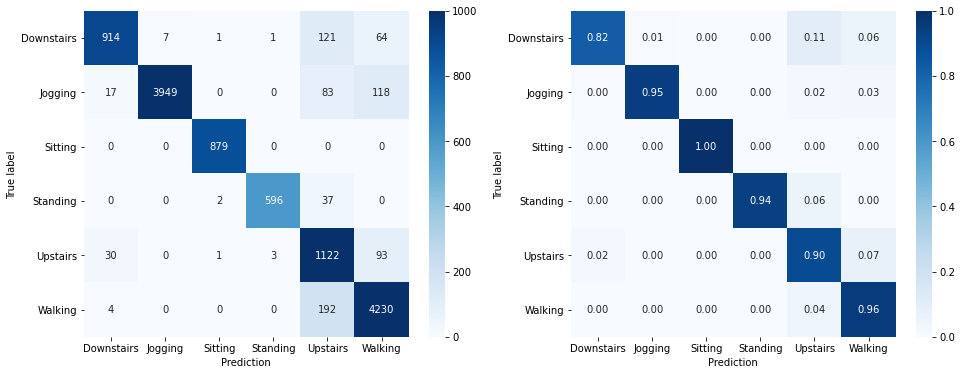

In [71]:
# The confusion matrix for the combined model on the WISDM testing dataset
plot_cm(X_wd_test_rs,y2_wd_test,model_cb,enc=enc)

In [74]:
model_cb.evaluate(X_ms_test_rs,y_ms_test)

328/328 [==============================] - 10s 31ms/step - loss: 0.8108 - accuracy: 0.9014


[0.8108214139938354, 0.9013640880584717]

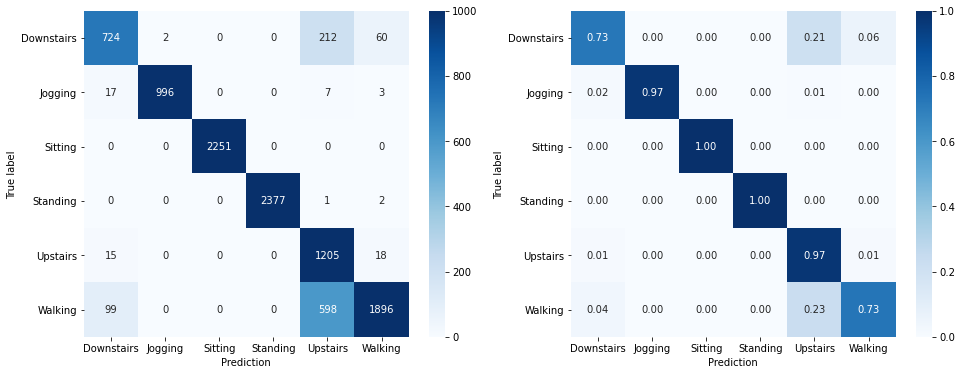

In [58]:
# The confusion matrix for the combined model on the MS testing dataset
plot_cm(X_ms_test_rs,y_ms_test,model_cb,enc=enc)

In [75]:
model_cb.evaluate(X_cb_test_rs,y_cb_test)

718/718 [==============================] - 24s 33ms/step - loss: 0.7467 - accuracy: 0.9212


[0.7467480301856995, 0.9212097525596619]

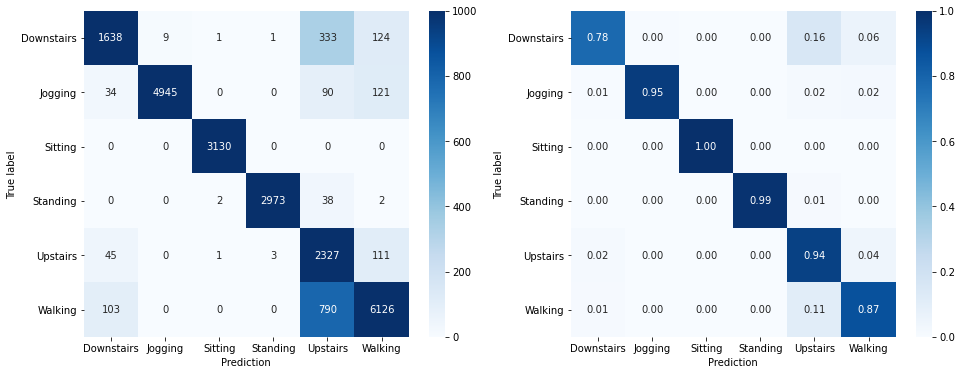

In [59]:
# The confusion matrix for the combined model on the combined testing dataset
plot_cm(X_cb_test_rs,y_cb_test,model_cb,enc=enc)

- The CNN model built from the combined datasets had the following classification accuracies    

|     	| WISDM dataset 	| MS dataset  	| Combined dataset 	|   
|-------------	|-------	|------	|----------	|   
| Accuracy   	| 0.94  	| 0.90 	| 0.92     	|  
- From the confusion matrix, one can see that the model could classify some of the activies (such as jogging, sitting, standing and upstairs) more accurate than other activities (such as downstairs and walking).

#### Evaluate the models built from the MS datasets (12 features)

In [60]:
# Select all the featuers collected by iPhones (Attitude, gravity, rotation rate, and user acceleration)
cols_12 = df_ms.columns[:12]

In [72]:
# scale the all the selected features in the MS datasets
df_ms_train,df_ms_test = robustscale_data(df_ms_train,df_ms_test,cols_12)
df_ms_test.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,...,weight,height,age,gender,trial,x_axis,y_axis,z_axis,user_id,activity
992434,-0.224624,-0.286674,-0.164736,-0.231529,0.140885,-0.157092,0.197856,1.037395,-1.158822,-0.474556,...,54.0,164.0,26.0,0.0,1.0,-0.298364,-0.334976,-0.173145,67.0,Downstairs
992435,-0.228428,-0.279494,-0.175891,-0.238157,0.138718,-0.166885,0.780960,1.436103,-1.416717,-0.270637,...,54.0,164.0,26.0,0.0,1.0,-0.271320,-0.550886,-0.213503,67.0,Downstairs
992436,-0.235533,-0.268435,-0.190086,-0.250021,0.135243,-0.181463,1.037861,0.825558,-2.016847,0.953937,...,54.0,164.0,26.0,0.0,1.0,-0.085477,-0.587546,-0.309718,67.0,Downstairs
992437,-0.244925,-0.255494,-0.205022,-0.265793,0.130959,-0.197812,1.085719,0.366568,-2.015011,2.156050,...,54.0,164.0,26.0,0.0,1.0,0.093497,-0.558702,-0.274414,67.0,Downstairs
992438,-0.251631,-0.244433,-0.216293,-0.278595,0.127118,-0.211785,0.846843,0.582612,-1.597334,1.865288,...,54.0,164.0,26.0,0.0,1.0,0.036266,-0.380323,-0.100965,67.0,Downstairs


In [62]:
# Creating training and testing datasets used to build models by activities, then merge all together
X2_ms_train = np.zeros((0,200,12))
y2_ms_train = np.zeros((0,1))
X2_ms_test = np.zeros((0,200,12))
y2_ms_test = np.zeros((0,1))
for act in activity_list:
    X1,y1,X2,y2 = create_train_test(time_steps=200,step=40,df_train=df_ms_train[df_ms_train['activity']==act],df_test=df_ms_test[df_ms_test['activity']==act],start=0,end=12)
    X2_ms_train = np.append(X2_ms_train,X1,axis=0)
    y2_ms_train = np.append(y2_ms_train,y1,axis=0)
    X2_ms_test = np.append(X2_ms_test,X2,axis=0)
    y2_ms_test = np.append(y2_ms_test,y2,axis=0)

In [63]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y2_ms_train)

y2_ms_train = enc.transform(y2_ms_train)
y2_ms_test = enc.transform(y2_ms_test)

In [64]:
X2_ms_test_rs = reshape_4cnn(X2_ms_test)

In [76]:
model_12ms4.evaluate(X2_ms_test_rs,y2_ms_test)

328/328 [==============================] - 70s 213ms/step - loss: 0.6886 - accuracy: 0.9298


[0.6885741949081421, 0.9297910928726196]

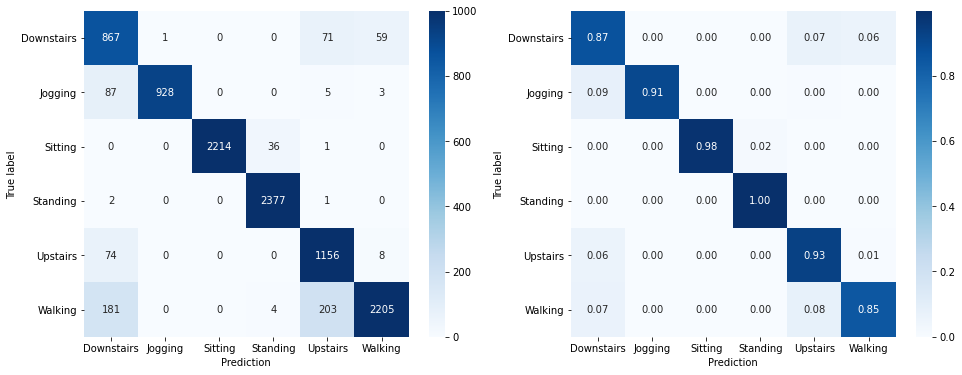

In [67]:
plot_cm(X2_ms_test_rs,y2_ms_test,model_12ms4,enc=enc)

In [77]:
model_12ms.evaluate(X2_ms_test_rs,y2_ms_test)

328/328 [==============================] - 64s 194ms/step - loss: 0.0270 - accuracy: 0.9941


[0.026988819241523743, 0.9940856695175171]

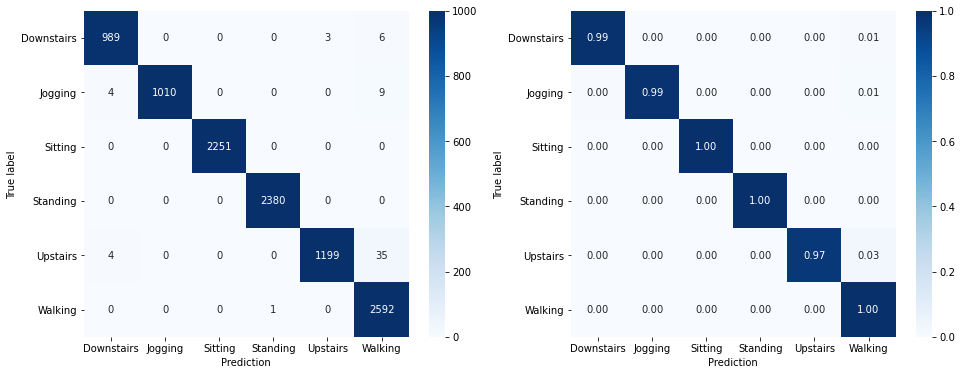

In [65]:
plot_cm(X2_ms_test_rs,y2_ms_test,model_12ms,enc=enc)

- The CNN model built from the MS datasets using all 12 feature had high classification accuracies, especially when using all subjects in training, the accuracy was almost perfect.  

|All subjects in training     	|  No 	| Yes  	|
|-------------	|-------	|------	|  
| Accuracy   	| 0.93  	| 0.99 	|  
- From the confusion matrix, one can have similar observations that the model could classify some of the activies (such as jogging, sitting, standing and upstairs) more accurate than other activities (such as downstairs and walking) for the first case. However, when all subjects' data was used in training, the model have great accuracies for all activities.

### 2. Evaluate the models with dataset collected by myself

In [89]:
#define a function to reading the datasets I collected
def read_in_iPhone_data(path = './01_rawdata/collection/', file = 'z_walk1.csv', merge_wd = True):
    df = pd.read_csv(path+file)
    df['x_axis']=df['userAcceleration.x']+df['gravity.x']
    df['y_axis']=df['userAcceleration.y']+df['gravity.y']
    df['z_axis']=df['userAcceleration.z']+df['gravity.z']
    if merge_wd:      # only need 3 featuress if work with WISDM datasets
        return df[['x_axis','y_axis','z_axis']]
    else:             # all the features could be used if work with MS datasets
        col = ['attitude.roll', 'attitude.pitch',
       'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z',
       'rotationRate.x', 'rotationRate.y',
       'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y',
       'userAcceleration.z']
        return df[col]    

In [118]:
#define a function to scale the features, the scaler need to match with the ones used for building the models
def robustscale_data2(df,cols,scaler=RobustScaler()):
    scale_columns = cols
    df.loc[:, scale_columns] = scaler.fit_transform(df[scale_columns].to_numpy())
    return df

In [ ]:
def robustscale_data(df_train,df_test,cols,scaler=RobustScaler()):
    scale_columns = cols
    scaler = scaler.fit(df_train[scale_columns])
    df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
    df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())
    return df_train,df_test

In [81]:
df = read_in_iPhone_data()

In [82]:
df.head()

,x_axis,y_axis,z_axis
0,0.121612,-0.494126,-0.931396
1,0.125077,-0.517579,-0.988495
2,0.105133,-0.492829,-1.029984
3,0.053482,-0.464905,-0.957855
4,0.029190,-0.445298,-0.990738


In [83]:
df = robustscale_data(df,['x_axis', 'y_axis', 'z_axis'])

In [84]:
df.tail()

,x_axis,y_axis,z_axis
13976,1.727623,-3.970266,-2.409552
13977,1.720784,-3.962965,-2.390196
13978,1.598563,-3.953000,-2.368218
13979,1.608809,-4.018720,-2.419286
13980,1.569607,-4.032458,-2.359924


In [85]:
def create_dataset_X(X, time_steps=1, step=1):
    '''
    This function is very similar as the above function. The only difference is this function does not need inputting labels
    Using this function to create validation datasets.
    '''
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
#        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
#        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs)#, np.array(ys).reshape(-1, 1)

In [86]:
def map_preds(pred):
    out = []
    act_dict = {0:'Downstairs', 1:'Jogging', 2:'Sitting', 3:'Standing', 4:'Upstairs',
        5:'Walking'}    
    for i in range(pred.shape[0]):
        out.append(act_dict[np.argmax(pred[i])])
    return out        

In [93]:
#Evaluate the collected by the model built from the combined MS and WISDM datasets

collection_list = ['b_walk1.csv','d_walk1.csv','d_walk2.csv','l_walk1.csv','z_walk1.csv','z_walk1_left.csv','d_jogging1.csv','z_jogging1.csv']
for i, act in enumerate(collection_list):
    if i>=6:
        act_name = 'Jogging'
    else:
        act_name = 'Walking'
        
    df = read_in_iPhone_data(file=act)
    df = robustscale_data(df,['x_axis', 'y_axis', 'z_axis'])
    TIME_STEPS = 200
    STEP = 40

    X_test = create_dataset_X(
        df[df.columns[-3:]],
        TIME_STEPS,
        STEP
    )
    X_test_rs = np.array(X_test).reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
    print(act)
#     print("MS lstm model acc:")
#     print(np.mean(np.array(map_preds(model.predict(X_test)))==act_name))
#     print("Combine lstm model acc:")
#     print(np.mean(np.array(map_preds(model_ep20.predict(X_test)))==act_name))
    print("Combine CNN model")
    print(np.mean(np.array(map_preds(model_cb.predict(X_test_rs)))==act_name))
    print("\n")

b_walk1.csv
Combine CNN model
0.9176470588235294


d_walk1.csv
Combine CNN model
0.6589147286821705


d_walk2.csv
Combine CNN model
0.38271604938271603


l_walk1.csv
Combine CNN model
0.27204030226700254


z_walk1.csv
Combine CNN model
0.8492753623188406


z_walk1_left.csv
Combine CNN model
0.7338709677419355


d_jogging1.csv
Combine CNN model
0.01011804384485666


z_jogging1.csv
Combine CNN model
0.02996845425867508




In [ ]:
np.mean(np.array(map_preds(model_cb.predict(X_test_rs)))==act_name)

In [111]:
# map_preds(model_12ms.predict(X_test_rs))

In [107]:
#Evaluate the collected by the model built from the MS datasets with 12 features

collection_list = ['b_walk1.csv','d_walk1.csv','d_walk2.csv','l_walk1.csv','z_walk1.csv','z_walk1_left.csv','d_jogging1.csv','z_jogging1.csv']
for i, act in enumerate(collection_list):
    if i>=6:
        act_name = 'Jogging'
    else:
        act_name = 'Walking'
        
    df = read_in_iPhone_data(file=act,merge_wd=False)
    df = robustscale_data(df,df.columns)
    TIME_STEPS = 200
    STEP = 40

    X_test = create_dataset_X(
        df[df.columns[0:12]],
        TIME_STEPS,
        STEP
    )
    X_test_rs = np.array(X_test).reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
    print(act)
#     print("MS lstm model acc:")
#     print(np.mean(np.array(map_preds(model.predict(X_test)))==act_name))
#     print("Combine lstm model acc:")
#     print(np.mean(np.array(map_preds(model_ep20.predict(X_test)))==act_name))
    print("12feature CNN model")
    print(np.mean(np.array(map_preds(model_12ms4.predict(X_test_rs)))==act_name))
    print("12feature/all subjects CNN model")
    print(np.mean(np.array(map_preds(model_12ms.predict(X_test_rs)))==act_name))
    print("\n")

b_walk1.csv
12feature CNN model
0.058823529411764705
12feature/all subjects CNN model
0.020588235294117647


d_walk1.csv
12feature CNN model
0.0103359173126615
12feature/all subjects CNN model
0.0


d_walk2.csv
12feature CNN model
0.19506172839506172
12feature/all subjects CNN model
0.019753086419753086


l_walk1.csv
12feature CNN model
0.005037783375314861
12feature/all subjects CNN model
0.0


z_walk1.csv
12feature CNN model
0.020289855072463767
12feature/all subjects CNN model
0.0


z_walk1_left.csv
12feature CNN model
0.056451612903225805
12feature/all subjects CNN model
0.29301075268817206


d_jogging1.csv
12feature CNN model
0.0
12feature/all subjects CNN model
0.0


z_jogging1.csv
12feature CNN model
0.0
12feature/all subjects CNN model
0.0




(12,)

In [127]:
df = read_in_iPhone_data(file=act,merge_wd=False)   

In [128]:
df.describe()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
count,25536.000000,25536.000000,25536.000000,25536.000000,25536.000000,25536.000000,25536.000000,25536.000000,25536.000000,25536.000000,25536.000000,25536.000000
mean,1.895279,-1.100199,-0.038367,0.278145,0.881562,0.186146,-0.008669,0.041682,-0.143141,0.038480,0.167972,-0.021935
std,1.007292,0.157308,1.758349,0.165636,0.094656,0.272842,3.590031,3.597413,1.704570,0.589827,0.966407,0.940387
min,-3.141507,-1.556666,-3.141313,-0.991323,-0.566193,-0.989564,-12.787753,-18.139231,-11.809419,-2.616409,-3.255205,-2.133897
25%,1.283150,-1.197658,-1.374156,0.220673,0.849804,-0.074117,-2.613737,-2.145113,-1.189354,-0.288610,-0.569993,-0.609981
50%,2.221672,-1.118346,0.203828,0.299151,0.899379,0.256311,0.034622,-0.257696,-0.274522,0.000309,-0.055889,-0.256750
75%,2.588422,-1.015613,1.651533,0.371406,0.931188,0.412636,2.206145,1.742267,0.722848,0.389439,0.819493,0.213944
max,3.141339,0.601880,3.140931,0.788990,0.999900,0.830725,12.913835,24.958141,9.645203,2.214679,4.563525,8.106944


In [129]:
df = robustscale_data2(df,df.columns)

In [130]:
df.describe()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
count,2.553600e+04,25536.000000,2.553600e+04,25536.000000,2.553600e+04,25536.000000,25536.000000,25536.000000,2.553600e+04,25536.000000,2.553600e+04,2.553600e+04
mean,-2.500572e-01,0.099683,-8.004626e-02,-0.139357,-2.189210e-01,-0.144149,-0.008982,0.077013,6.870651e-02,0.056296,1.611106e-01,2.849964e-01
std,7.717104e-01,0.864114,5.811398e-01,1.098872,1.163078e+00,0.560536,0.744838,0.925408,8.914174e-01,0.869889,6.955137e-01,1.141352e+00
min,-4.108860e+00,-2.407756,-1.105580e+00,-8.561338,-1.800805e+01,-2.559563,-2.660309,-4.599895,-6.032260e+00,-3.859187,-2.302518e+00,-2.278300e+00
25%,-7.190236e-01,-0.435670,-5.215288e-01,-0.520642,-6.091473e-01,-0.678840,-0.549465,-0.485524,-4.784181e-01,-0.426103,-3.699958e-01,-4.287175e-01
50%,-1.701147e-16,0.000000,-4.586630e-18,0.000000,-6.820873e-16,0.000000,0.000000,0.000000,1.451476e-17,0.000000,-2.497053e-18,3.368650e-17
75%,2.809764e-01,0.564330,4.784712e-01,0.479358,3.908527e-01,0.321160,0.450535,0.514476,5.215819e-01,0.573897,6.300042e-01,5.712825e-01
max,7.045793e-01,9.449455,9.707219e-01,3.249718,1.235147e+00,1.180093,2.672101,6.486590,5.187594e+00,3.265796,3.324549e+00,1.015105e+01


In [90]:
# define a function to plot the sensor data of a user provided activitiy
def plot_activity(df,activity = None,sensor = 0):
    sensor_dict = {
        0:'attitude',
        1:'gravity',
        2:'rotationRate',
        3:'userAcceleration',
        4:'axis' # This is the sum of gravity and userAcceleration
    }
    if sensor == 4:
        x ='x_'+sensor_dict[sensor]
        y ='y_'+sensor_dict[sensor]
        z ='z_'+sensor_dict[sensor]
    elif sensor == 0:
        x = sensor_dict[sensor]+'.roll'
        y = sensor_dict[sensor]+'.pitch'
        z = sensor_dict[sensor]+'.yaw'
    else:
        x = sensor_dict[sensor]+'.x'
        y = sensor_dict[sensor]+'.y'
        z = sensor_dict[sensor]+'.z'
    if activity == None:
        data = df[[x,y,z]][1800:2000]
        title = None
    else:
        data = df[df['activity'] == activity][[x,y,z]][1800:2000]
        title = activity
    
    axis = data.plot(figsize=(8, 6), 
                     title=activity)
    axis.legend(loc='lower left',bbox_to_anchor=(1.0,0.5)) 

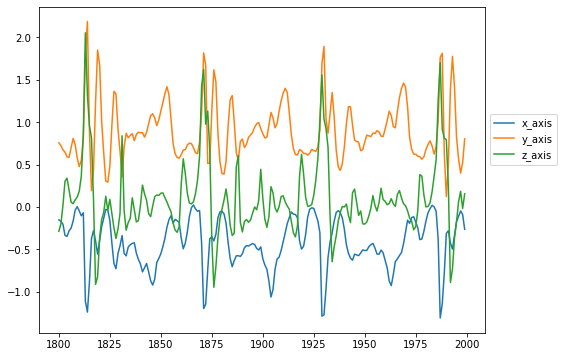

In [75]:
df_wk = read_in_iPhone_data(file='z_walk1.csv')
plot_activity(df_wk,sensor=4)

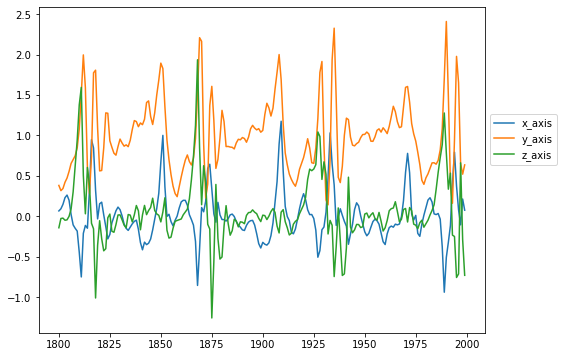

In [77]:
df_wk = read_in_iPhone_data(file='d_walk1.csv')
plot_activity(df_wk,sensor=4)

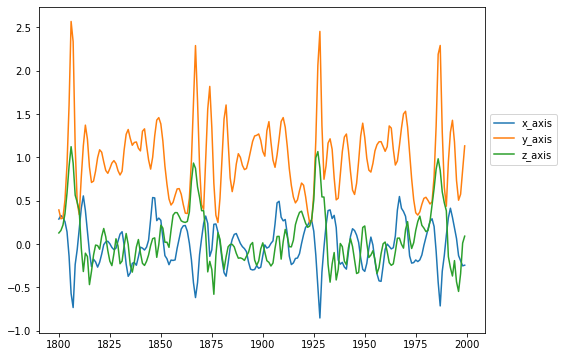

In [79]:
df_wk = read_in_iPhone_data(file='l_walk1.csv')
plot_activity(df_wk,sensor=4)

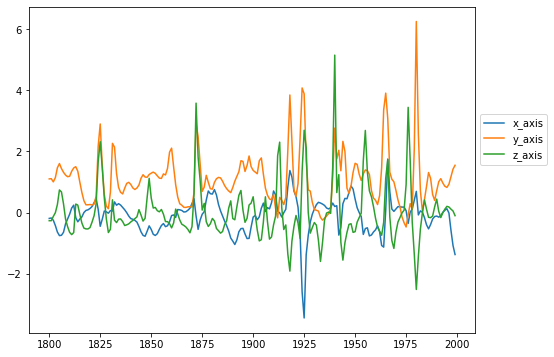

In [78]:
df_wk = read_in_iPhone_data(file='b_walk1.csv')
plot_activity(df_wk,sensor=4)

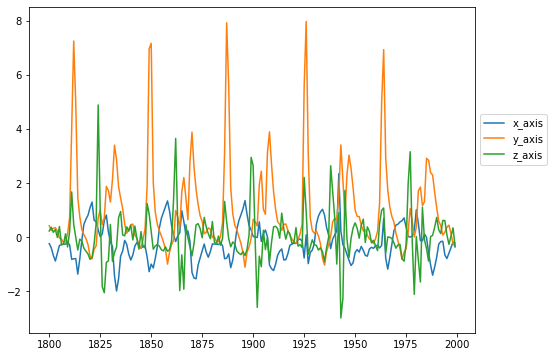

In [76]:
df_wk = read_in_iPhone_data(file='d_jogging1.csv')
plot_activity(df_wk,sensor=4)

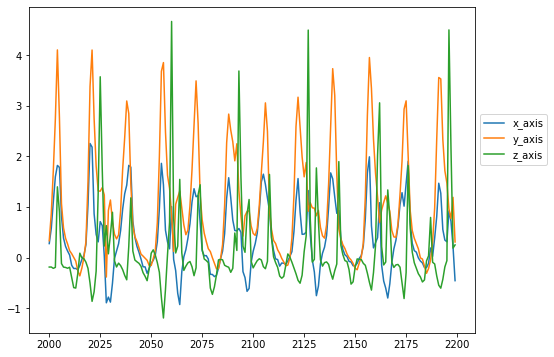

In [71]:
df_wk = read_in_iPhone_data(file='z_jogging1.csv')
plot_activity(df_wk,sensor=4)

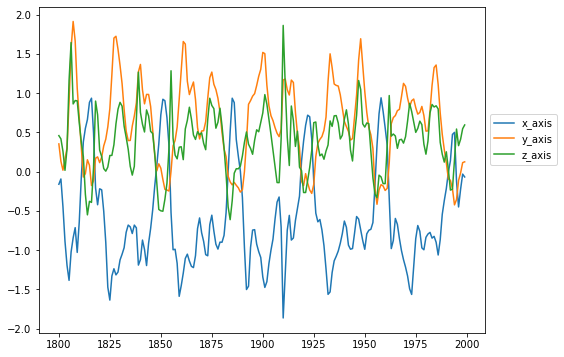

In [84]:
df_wk = read_in_iPhone_data(file='b_bike1.csv')
plot_activity(df_wk,sensor=4)

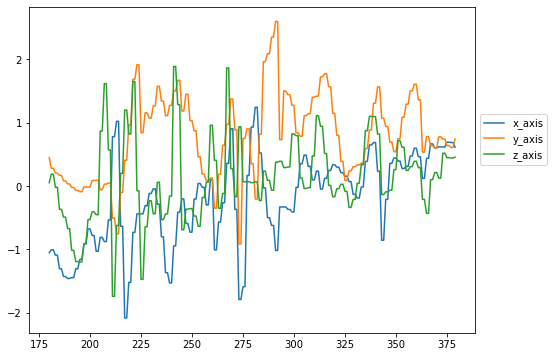

In [87]:
df_wk = read_in_iPhone_data(file='d_bike1.csv')
plot_activity(df_wk,sensor=4)

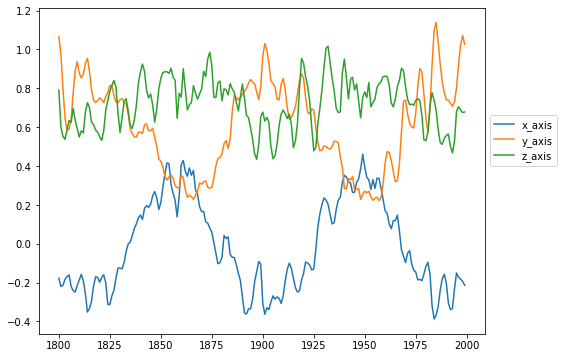

In [83]:
df_wk = read_in_iPhone_data(file='z_bike1.csv')
plot_activity(df_wk,sensor=4)

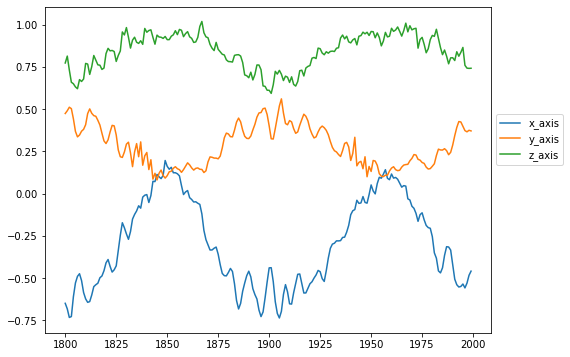

In [85]:
df_wk = read_in_iPhone_data(file='l_bike1.csv')
plot_activity(df_wk,sensor=4)

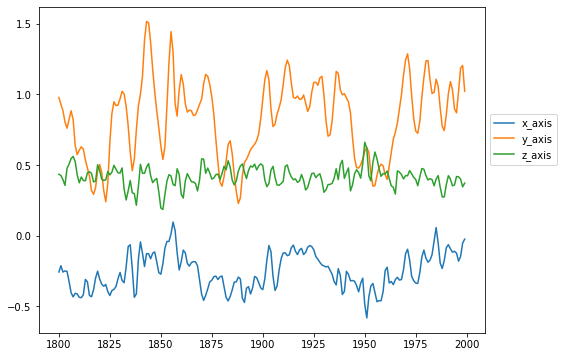

In [91]:
df_wk = read_in_iPhone_data(file='d_bike2.csv')
plot_activity(df_wk,sensor=4)

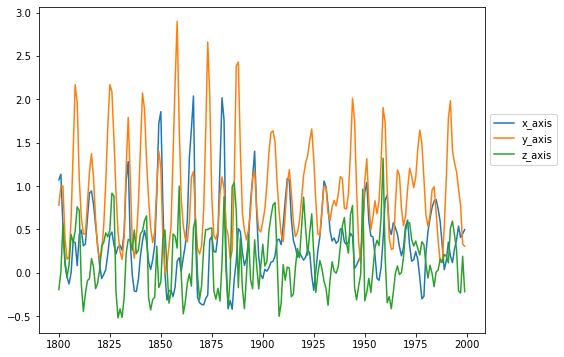

In [92]:
df_wk = read_in_iPhone_data(file='d_ripstick1.csv')
plot_activity(df_wk,sensor=4)